52 week high backtester

In [2]:
!pip install yfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.1 MB/s eta 0:00:00
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15548 sha256=c1e87cc5e2991bef7ca795aa7b005bc53066fe27862e29325e706487b4f6a04d
  Stored in directory: /Users/hianya/

In [ ]:
#imported neccessary libraries, since only price data was needed I chose to use Yahoo Finance

import yfinance as yf
import pandas as pd
import numpy as np
import datetime

In [ ]:
# Get ticker universe from GitHub, used raw url if someone wants to run locally
ticker_universe = pd.read_csv("https://raw.githubusercontent.com/EarthWolves/SFIC-Potfolio-Strategy-Backtests/refs/heads/main/stock_universe.csv")

tickers = ticker_universe["Symbol"].tolist()
tickers = [t.replace('.', '-') for t in tickers]

In [ ]:
# download prices for last 25 years as this is the period backtest will cover
#prices are recorded weekly since the model uses a 52-week high basis
prices = yf.download(tickers, start="2000-01-01", interval="1wk")

/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_78945/3194253576.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start="2000-01-01", interval="1wk")
[*********************100%***********************]  503 of 503 completed

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


In [ ]:
prices = prices.dropna(axis=1, how='all') # Drop columns with all NaNs
 
# calculate 52-week rolling high, shifted by 1 to avoid lookahead bias
# min_periods = 2 to ensure at least some data is present, but that a stock does not get selected on its first week of trading
rolling_high = prices.shift(1).rolling(window=52, min_periods=2).max()

# calculate distance to 52-week high to determine which stocks are closest and should therefore be selected
dist_to_high = (rolling_high - prices) / rolling_high

In [ ]:
#calculate distance to high on a monthly basis, as we rebalance monthly
monthly_dist_to_high = dist_to_high.resample('M').last()
monthly_portfolios = {}

# For each month, select the 50 stocks closest to their 52-week high
for date, row in monthly_dist_to_high.iterrows():
    top_50 = row.dropna().nsmallest(50).index.tolist()
    monthly_portfolios[date] = [tup[1] for tup in top_50] # to get rid of multiindex

/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_78945/1506841042.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_dist_to_high = dist_to_high.resample('M').last()


In [ ]:
close_prices = prices['Close'] # Focus on close prices for return calculations
returns = close_prices.pct_change().shift(-1) # Daily returns, shifted to represent next month's return

/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_78945/2432593434.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().shift(-1)


In [ ]:
portfolio_value = [50000.00]  # starting with $50,000 allocation
dates = sorted(monthly_portfolios.keys())

# calculate portfolio value over time, rebalancing monthly and assigning equal weight to each selected stock
for i in range(len(dates) - 1):
    date = dates[i]
    next_date = dates[i+1]
    
    tickers = monthly_portfolios[date]
    
    try:
        monthly_ret = returns.loc[date, tickers]
        monthly_ret = monthly_ret.dropna()
        
        if len(monthly_ret) > 0:
            avg_return = monthly_ret.mean()
        else:
            avg_return = 0

        new_value = portfolio_value[-1] * (1 + avg_return)
        portfolio_value.append(new_value)
    
    except KeyError:
        portfolio_value.append(portfolio_value[-1])

<Axes: title={'center': 'Backtested Portfolio Value for 52-week High Momentum Strategy'}, xlabel='Date', ylabel='Portfolio Value ($)'>

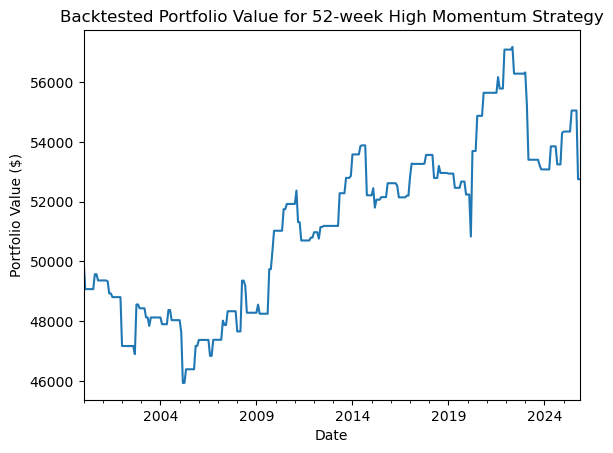

In [97]:
# generate chart of portfolio value over timea
portfolio_series = pd.Series(portfolio_value, index=dates)
portfolio_series.plot(title='Backtested Portfolio Value for 52-week High Momentum Strategy', ylabel='Portfolio Value ($)', xlabel='Date')